# Connecting G-drive and importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2 as cv
import cv2 
from google.colab.patches import cv2_imshow
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import xlwt
from xlwt import Workbook
import xlrd
import time

In [ ]:
path_to_cropped_folder = "/content/gdrive/MyDrive/Extrusion-study/Cropped-images"
path_to_cropped_gray_image_folder = "/content/gdrive/MyDrive/Extrusion-study/Gray-cropped"
path_to_cropped_gray_binary_folder = "/content/gdrive/MyDrive/Extrusion-study/Binary-grayed-cropped"
path_to_results_folders = "/content/gdrive/MyDrive/Extrusion-study/Results"

# Generating cropped, grayscale and binary images

In [ ]:
# NO NEED TO RUN AGAIN-  Cropped images are saved in G-Drive

for name in sorted(glob.glob("/content/gdrive/MyDrive/Extrusion-study/Final-image-set/*.jpg")):
  image = cv.imread(name)
  image_name_only = name.split('set/')[1] # with extension but without path
  print("Size of", image_name_only, "is ",image.shape) # Print image shape (height, width, channel)

  # cropping and saving all images
  cropped_image = image[500:1000, 2200:2800]
  cv2.imwrite(path_to_cropped_folder + "/" + image_name_only.split(".")[0] + "_cropped." + image_name_only.split(".")[1], cropped_image)
  print("Size of", image_name_only, "is ",cropped_image.shape) # Print image shape (height, width, channel)

In [ ]:
# NO NEED TO RUN AGAIN - Gray images are saved in G-Drive

for name in sorted(glob.glob(path_to_cropped_folder + "/*.jpg")):
  image = cv.imread(name)
  image_name_only = name.split('Cropped-images/')[1] # with extension but without path
  # converting to gray scale and saving
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(path_to_cropped_gray_image_folder + "/" + image_name_only.split(".")[0] + "_grayed." + image_name_only.split(".")[1], gray)
  print("Size of", image_name_only, "is ",gray.shape) # Print image shape (height, width, channel)

In [ ]:
# NO NEED TO RUN AGAIN - Binary images are saved in G-Drive
# OpenCV reads image in 3 channels, even gray and binary. This is not an error. 

for name in sorted(glob.glob(path_to_cropped_gray_image_folder + "/*.jpg")):
  image = cv.imread(name)
  image_name_only = name.split('Gray-cropped/')[1] # with extension but without path
  # (image, threshold, max pixel to set), values below threhold are set to 0
  threshold ,binary_img = cv.threshold(image,90,255,cv.THRESH_BINARY)
  cv2.imwrite(path_to_cropped_gray_binary_folder + "/" + image_name_only.split(".")[0] + "_binary." + image_name_only.split(".")[1], binary_img)
  print("Size of", image_name_only, "is ",binary_img.shape) # Print image shape (height, width, channel)

# Calculation of filament diameter 'At build plane' and 'Near build plane'

1 division = 0.4mm = 16 pixel

Therefore, 1 pixel = 0.025 mm


In [ ]:
# count the number of occurrences
def countX(lst, x):
  lst = lst.tolist() # need to convert numpay array to list
  return lst.count(x)

nozzle tip @ 111

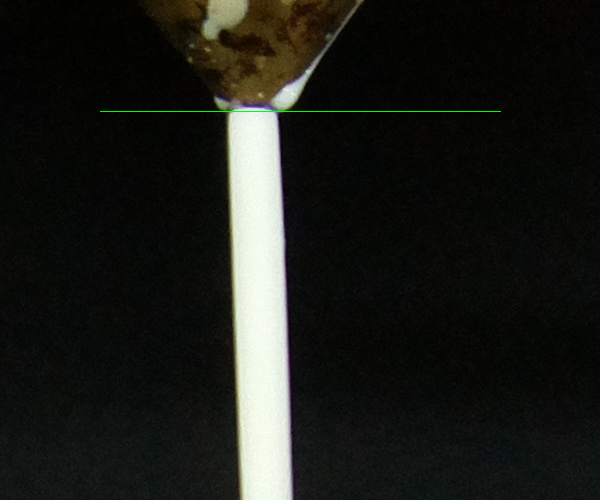

In [ ]:
#cv2.line(image, start_point, end_point, color, thickness)
height = 111
image = cv.imread("/content/gdrive/MyDrive/Extrusion-study/Cropped-images/H_Dec_4_2021_800_0000_B_cropped.jpg")
image_lined = cv2.line(image, (100,height), (500,height), (0,255,0), 1) # col x row
cv2_imshow(image_lined)

# Saving diameter values to Google Sheet

In [ ]:
wb = Workbook()
excel_file_name = "results" + ".xlsx"

In [ ]:
# NO NEED TO RUN THIS - SPREAD SHEET ALREADY SAVED
# add_sheet is used to create sheet.
sheet1 = wb.add_sheet('Sheet_1',cell_overwrite_ok=True)

column = 0
for height in list(range(111,491,2)): # this will measure diameter from nozzle tip to upto 9.45 mm
  row = 1
  dist_from_nozzle_in_mm = (height-110)*0.025
  sheet1.write(0, 0, 'image_name')
  sheet1.write(0, column + 1, dist_from_nozzle_in_mm)

  for name in sorted(glob.glob(path_to_cropped_gray_binary_folder + "/*.jpg")):
    image = cv.imread(name,cv2.IMREAD_GRAYSCALE)
    image_name_only = name.split('Binary-grayed-cropped/')[1] # with extension but without path
    intensity = image[height,100:500]
    count_255 = countX(intensity,255)
    filament_dia_in_mm = count_255*0.025
    if column == 0:
      sheet1.write(row, column, image_name_only) # will be saved in row+1 x column+1 cell
    sheet1.write(row, column+1, filament_dia_in_mm) # will be saved in row+1 x column+1 cell
    print("The pixel diameter of", image_name_only, "filament is ", count_255)
    row = row+1
  column = column+1

wb.save(path_to_results_folders + "/" + excel_file_name)

In [ ]:
wb = xlrd.open_workbook(path_to_results_folders + "/" + excel_file_name)
sheet = wb.sheet_by_index(0) # opening the first sheet
 
distance = [] 
diameter = []
diameter_mat = []

for i in range(1,sheet.ncols):
  x = sheet.cell_value(0, i)
  distance.append(x)

for ii in range(1,sheet.nrows):
  diameter = []

  for i in range(1,sheet.ncols):
    x = sheet.cell_value(ii, i)
    diameter.append(x)
  diameter_mat.append(diameter)


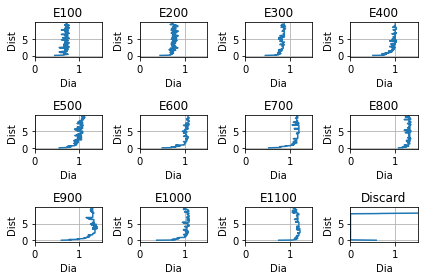

In [ ]:
# the plot below shows raw data showing how diamter changes with respect to speed, this is just for purpose of initial exploration

fig = 1
for i in range(0,sheet.nrows-1):
  plt.subplot(3, 4, fig)
  plt.xlim([0, 1.5])
  if fig ==12:
    plt.title("Discard")
  else:
    plt.title('E' + str(fig*100))
  plt.tight_layout()
  plt.plot(diameter_mat[i],distance)
  plt.xlabel("Dia")
  plt.ylabel("Dist")
  plt.grid()
  fig = fig + 1


plt.savefig("graph.png", dpi=900)

# Regression

In this section, removing noise and studying effect of extrusion speed & diameter, evolution of diamter over a finite length from nozzle tip. 

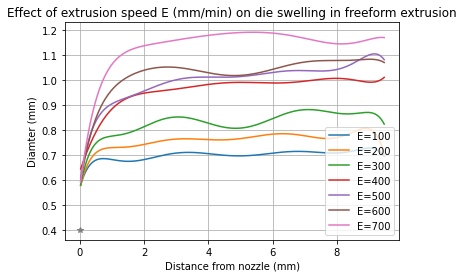

In [ ]:
# using ployfit function

E = 100
for i in range(0,7): # using E100 to E700
  
  p,res, _, _, _ = np.polyfit(distance,diameter_mat[i],8,full=True)
  dia_val = np.polyval(p,distance) # evaluate p at distance 
  plt.plot(distance,dia_val,label='E=%s' %E)
  E = E + 100

plt.legend(loc ="lower right")
plt.grid()
plt.plot(0, 0.4,'*') # nozzle diameter
plt.xlabel("Distance from nozzle (mm)")
plt.ylabel("Diamter (mm)")
plt.title('Effect of extrusion speed E (mm/min) on die swelling in freeform extrusion')
plt.show


plt.savefig("combined_diamter_for_all_E.png", dpi=900)

<function matplotlib.pyplot.show>

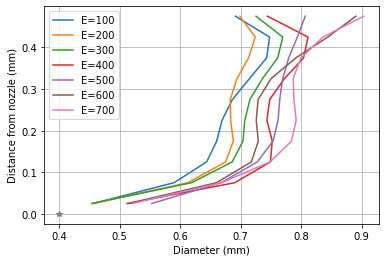

In [ ]:
E = 100
limit = 10; # concentrating filament diameter near nozzle, change the limit as you see fit
for i in range(0,7): # using E100 to E700
  
  p = np.polyfit(distance[0:limit],diameter_mat[i][0:limit],4)
  dia_val = np.polyval(p,distance[0:limit]) # evaluate p at distance 
  plt.plot(dia_val,distance[0:limit],label='E=%s' %E)
  E = E + 100


plt.legend(loc ="upper left")
plt.grid()
plt.plot(0.4, 0,'*') # nozzle diameter
plt.xlabel("Diameter (mm)")
plt.ylabel("Distance from nozzle (mm)")
plt.show


#plt.savefig("combined_diamter_for_all_E_near_nozzle.png", dpi=900)

In [ ]:
wb = xlrd.open_workbook(path_to_results_folders + "/" + excel_file_name)
sheet = wb.sheet_by_index(0) # opening the first sheet

# diamter for all E's at a particular dist from nozzle 
dist_from_nozzle_in_spreadsheet = 40+1 # distance.index(2.025), +1 added beacase 1st row is names

dia_at_particular_dist_mat = []

for dist_from_nozzle_in_spreadsheet in range(1,sheet.ncols):
  dia_at_particular_dist = []
  for i in range(1,sheet.nrows):
    x = sheet.cell_value(i,dist_from_nozzle_in_spreadsheet)
    dia_at_particular_dist.append(x)
    dia_at_particular_dist = dia_at_particular_dist[0:7] # removing values after E700
  dia_at_particular_dist_mat.append(dia_at_particular_dist)

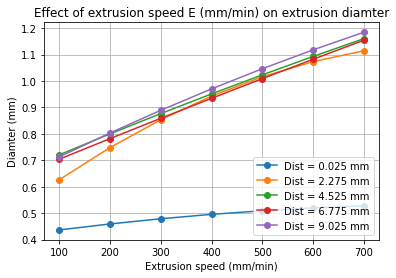

In [ ]:
E = [100,200,300,400,500,600,700]
i = 0
for d in distance:
  if i > sheet.ncols:
    break
  
  p,res, _, _, _ = np.polyfit(E,dia_at_particular_dist_mat[i],2,full=True)
  dia_val = np.polyval(p,E) # evaluate p

  #plt.plot(dia_at_particular_dist_mat[i],E,marker = 'o',label='Dist = %s mm' %distance[i])
  plt.plot(E,dia_val,marker = 'o',label='Dist = %s mm' %distance[i])
  i = i + 45


plt.legend(loc ="lower right")
plt.grid()
plt.xlabel("Extrusion speed (mm/min)")
plt.ylabel("Diamter (mm)")
plt.title('Effect of extrusion speed E (mm/min) on extrusion diamter')
plt.savefig("evolution_of_dia_as_function_of_E.png", dpi=900)